In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, project_root)

import pandas as pd
from src.data_loading import load_compas_sex, load_compas_race
from src.modeling import train_and_predict
from src.metrics import compute_metrics, viz_metrics_2x3, compare_viz_metrics_2x3

from sklearn.model_selection import StratifiedShuffleSplit

/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_di

In [2]:
# 1) Retrieve data
protected = 'race'
privileged_value   = 0.0
unprivileged_value = 1.0

ds, df = load_compas_race()
feature_cols = [c for c in df.columns if c not in ('label','race')]

# 2) Run experiment, Evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred = train_and_predict(
        df, feature_cols, train_idx, test_idx
    )
    m = compute_metrics(test_df, y_test, y_pred, protected, privileged_value, unprivileged_value)
    results.append(m)

# 3) Aggregate results
compas_race_metrics = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean', 'std'])

In [3]:
compas_race_metrics_agg

,accuracy,f1_score,SPD,DI,EOD,AOD
mean,0.673070,0.597067,-0.179721,0.575375,-0.208976,-0.159877
std,0.010989,0.012907,0.024342,0.048820,0.038348,0.023623


In [4]:
# 1) Retrieve data
protected = 'sex'
privileged_value   = 0.0
unprivileged_value = 1.0

ds, df = load_compas_sex()
feature_cols = [c for c in df.columns if c not in ('label','sex')]

# 2) Run experiment, Evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred = train_and_predict(
        df, feature_cols, train_idx, test_idx
    )
    m = compute_metrics(test_df, y_test, y_pred, protected, privileged_value, unprivileged_value)
    results.append(m)

# 3) Aggregate results
compas_sex_metrics = pd.DataFrame(results)
compas_sex_metrics_agg = compas_sex_metrics.agg(['mean', 'std'])

In [5]:
compas_sex_metrics_agg

,accuracy,f1_score,SPD,DI,EOD,AOD
mean,0.674401,0.601044,-0.284224,0.324980,-0.331084,-0.263587
std,0.010802,0.013216,0.030753,0.059045,0.055550,0.034169


---------------------------------------------------------------------------------------------
## Visualization

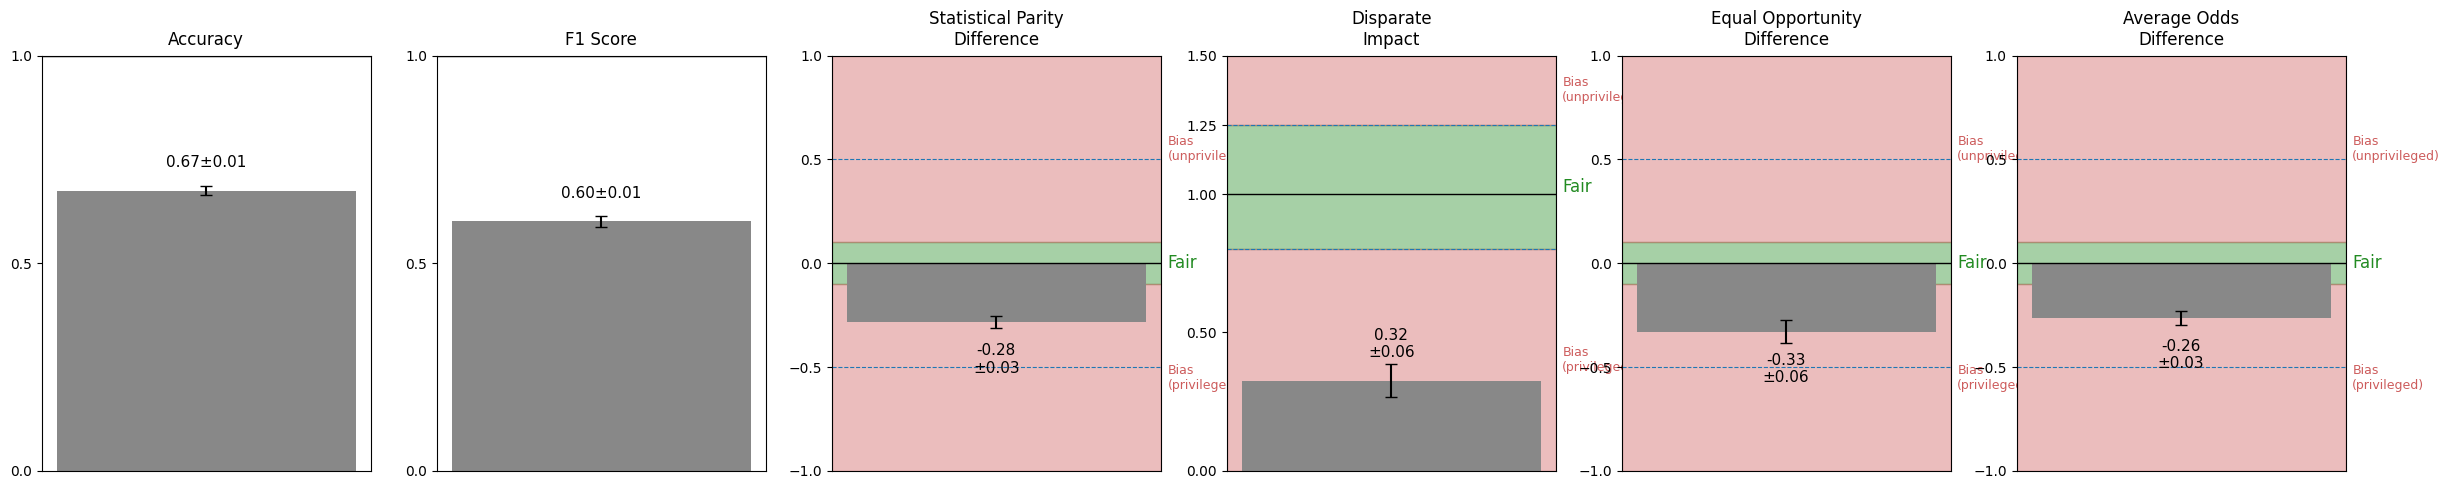

In [6]:
import matplotlib.pyplot as plt

# 1) Metrics in the new order
metrics = ['accuracy', 'f1_score', 'SPD', 'DI', 'EOD', 'AOD']
titles  = [
    'Accuracy',
    'F1 Score',
    'Statistical Parity\nDifference',
    'Disparate\nImpact',
    'Equal Opportunity\nDifference',
    'Average Odds\nDifference'
]

mean_vals = compas_sex_metrics_agg.loc['mean',  metrics]
std_vals  = compas_sex_metrics_agg.loc['std',   metrics]

fair_bands = {'SPD':(-0.1,0.1), 'DI':(0.8,1.25), 'EOD':(-0.1,0.1), 'AOD':(-0.1,0.1)}
ylims      = {
    'accuracy': (0.0,1.0),
    'f1_score': (0.0,1.0),
    'SPD':      (-1.0,1.0),
    'DI':       (0.0,1.5),
    'EOD':      (-1.0,1.0),
    'AOD':      (-1.0,1.0)
}
yticks = {
    'accuracy': [0,0.5,1.0],
    'f1_score': [0,0.5,1.0],
    'SPD':      [-1,-0.5,0,0.5,1],
    'DI':       [0,0.5,1,1.25,1.5],
    'EOD':      [-1,-0.5,0,0.5,1],
    'AOD':      [-1,-0.5,0,0.5,1]
}

fig, axes = plt.subplots(
    1, len(metrics),
    figsize=(4 * len(metrics), 5),  
    sharey=False
)

bar_width = 0.3  # <- slimmer bars
for ax, metric, title in zip(axes, metrics, titles):
    m = mean_vals[metric]
    s = std_vals[metric]
    lo_y, hi_y = ylims[metric]
    y_offset = 0.05 * (hi_y - lo_y)

    if metric in ('accuracy','f1_score'):
        ax.axhline(1.0, color='black', linewidth=1)
        ax.bar([''], [m], yerr=[s], capsize=4, color='#888888', width=bar_width)
        ax.text(0, m + y_offset, f"{m:.2f}±{s:.2f}",
                ha='center', va='bottom', fontsize=11)
    else:
        lo_f, hi_f = fair_bands[metric]
        # fair/bias shading
        ax.axhspan(lo_f, hi_f, color='forestgreen', alpha=0.4)
        ax.axhspan(lo_y, lo_f, color='indianred', alpha=0.4)
        ax.axhspan(hi_f, hi_y, color='indianred', alpha=0.4)
        # reference lines
        if metric == 'DI':
            ax.axhline(1.0, color='black', linewidth=1)
            ax.axhline(lo_f, linestyle='--', linewidth=0.8)
            ax.axhline(hi_f, linestyle='--', linewidth=0.8)
        else:
            ax.axhline(0.0, color='black', linewidth=1)
            ax.axhline(0.5, linestyle='--', linewidth=0.8)
            ax.axhline(-0.5, linestyle='--', linewidth=0.8)
        # bar + error‐bar
        ax.bar([''], [m], yerr=[s], capsize=4, color='#888888', width=bar_width)
        # annotate mean±std with offset
        va = 'bottom' if m >= 0 else 'top'
        y_text = m + y_offset if m >= 0 else m - y_offset
        ax.text(0, y_text, f"{m:.2f}\n±{s:.2f}", ha='center', va=va, fontsize=11)
        # region labels
        ax.text(1.02, (lo_y+lo_f)/2, 'Bias\n(privileged)',
                transform=ax.get_yaxis_transform(),
                ha='left', va='center', color='indianred', fontsize=9)
        ax.text(1.02, (lo_f+hi_f)/2, 'Fair',
                transform=ax.get_yaxis_transform(),
                ha='left', va='center', color='forestgreen', fontsize=12)
        ax.text(1.02, (hi_f+hi_y)/2, 'Bias\n(unprivileged)',
                transform=ax.get_yaxis_transform(),
                ha='left', va='center', color='indianred', fontsize=9)

    ax.set_title(title, fontsize=12, pad=8)
    ax.set_ylim(lo_y, hi_y)
    ax.set_yticks(yticks[metric])
    ax.set_xticks([])

plt.subplots_adjust(
    left=0.02, right=0.98,
    top=0.88, bottom=0.05,
    wspace=0.2  
)
plt.show()


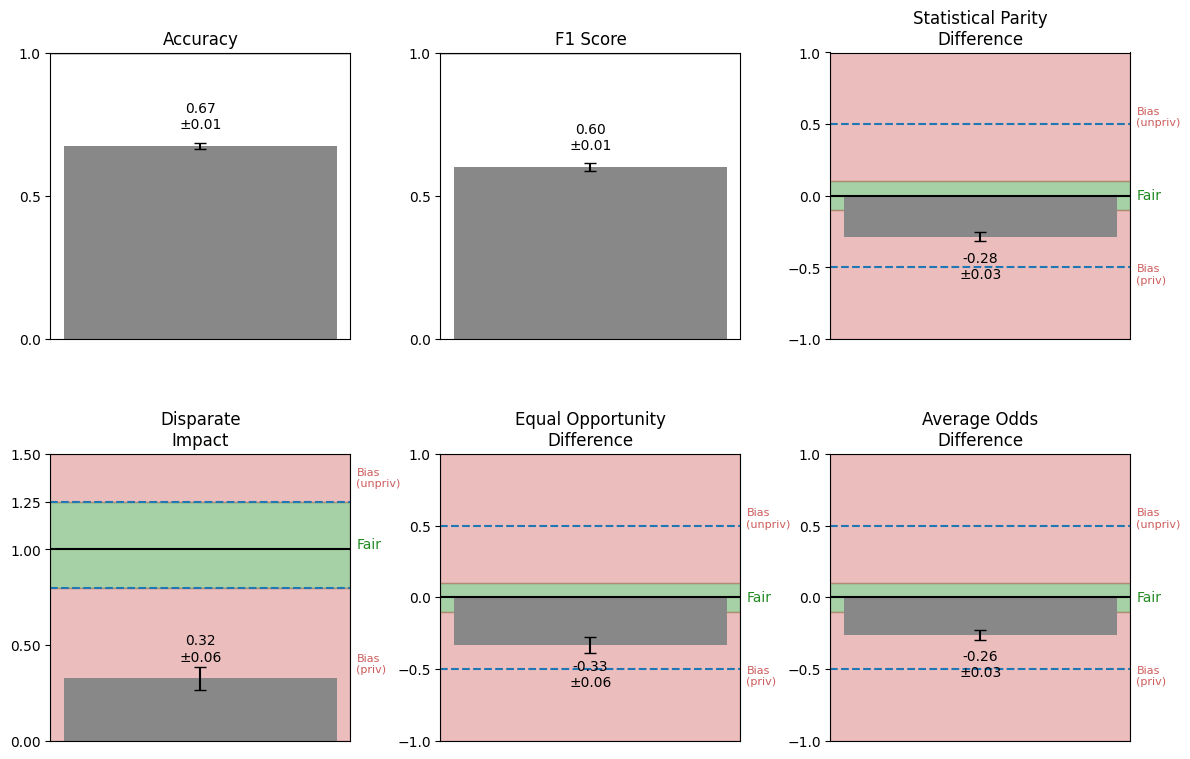

In [7]:
import matplotlib.pyplot as plt

metrics = ['accuracy', 'f1_score', 'SPD', 'DI', 'EOD', 'AOD']
titles  = [
    'Accuracy',
    'F1 Score',
    'Statistical Parity\nDifference',
    'Disparate\nImpact',
    'Equal Opportunity\nDifference',
    'Average Odds\nDifference'
]

mean_vals = compas_sex_metrics_agg.loc['mean', metrics]
std_vals  = compas_sex_metrics_agg.loc['std',  metrics]

fair_bands = {'SPD':(-0.1,0.1), 'DI':(0.8,1.25), 'EOD':(-0.1,0.1), 'AOD':(-0.1,0.1)}
ylims = {
    'accuracy': (0.0,1.0),
    'f1_score': (0.0,1.0),
    'SPD':      (-1.0,1.0),
    'DI':       (0.0,1.5),
    'EOD':      (-1.0,1.0),
    'AOD':      (-1.0,1.0)
}
yticks = {
    'accuracy': [0,0.5,1.0],
    'f1_score': [0,0.5,1.0],
    'SPD':      [-1,-0.5,0,0.5,1],
    'DI':       [0,0.5,1,1.25,1.5],
    'EOD':      [-1,-0.5,0,0.5,1],
    'AOD':      [-1,-0.5,0,0.5,1]
}

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=False)
axes = axes.flatten()
bar_width = 0.3

for ax, metric, title in zip(axes, metrics, titles):
    m = mean_vals[metric]
    s = std_vals[metric]
    lo_y, hi_y = ylims[metric]
    y_off = 0.05 * (hi_y - lo_y)

    if metric in ('accuracy','f1_score'):
        ax.axhline(1.0, color='black', linewidth=1)
        ax.bar([''], [m], yerr=[s], capsize=4, color='#888888', width=bar_width)
        ax.text(0, m+y_off, f"{m:.2f}\n±{s:.2f}", ha='center', va='bottom')
    else:
        lo_f, hi_f = fair_bands[metric]
        ax.axhspan(lo_f, hi_f, color='forestgreen', alpha=0.4)
        ax.axhspan(lo_y, lo_f, color='indianred', alpha=0.4)
        ax.axhspan(hi_f, hi_y, color='indianred', alpha=0.4)
        if metric=='DI':
            ax.axhline(1, color='black')
            ax.axhline(lo_f, linestyle='--')
            ax.axhline(hi_f, linestyle='--')
        else:
            ax.axhline(0, color='black')
            ax.axhline(0.5, linestyle='--')
            ax.axhline(-0.5, linestyle='--')
        ax.bar([''], [m], yerr=[s], capsize=4, color='#888888', width=bar_width)
        va = 'bottom' if m>=0 else 'top'
        y_text = m + y_off if m>=0 else m - y_off
        ax.text(0, y_text, f"{m:.2f}\n±{s:.2f}", ha='center', va=va)
        ax.text(1.02,(lo_y+lo_f)/2,'Bias\n(priv)', transform=ax.get_yaxis_transform(),
                ha='left', va='center', color='indianred', fontsize=8)
        ax.text(1.02,(lo_f+hi_f)/2,'Fair', transform=ax.get_yaxis_transform(),
                ha='left', va='center', color='forestgreen', fontsize=10)
        ax.text(1.02,(hi_f+hi_y)/2,'Bias\n(unpriv)', transform=ax.get_yaxis_transform(),
                ha='left', va='center', color='indianred', fontsize=8)

    ax.set_title(title, fontsize=12)
    ax.set_ylim(lo_y, hi_y)
    ax.set_yticks(yticks[metric])
    ax.set_xticks([])

plt.subplots_adjust(left=0.05, right=0.95, top=0.93, bottom=0.07, hspace=0.4, wspace=0.3)
plt.show()


-------------------------------------------------
with functions

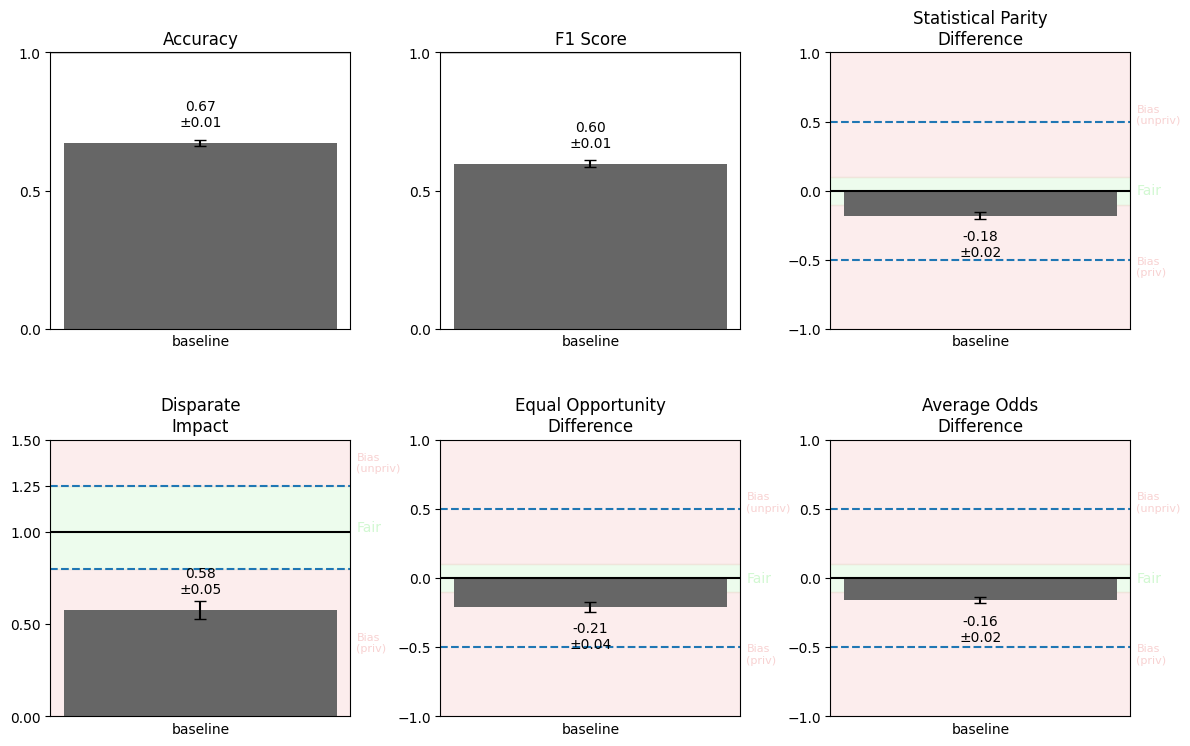

In [8]:
viz_metrics_2x3(compas_race_metrics_agg)

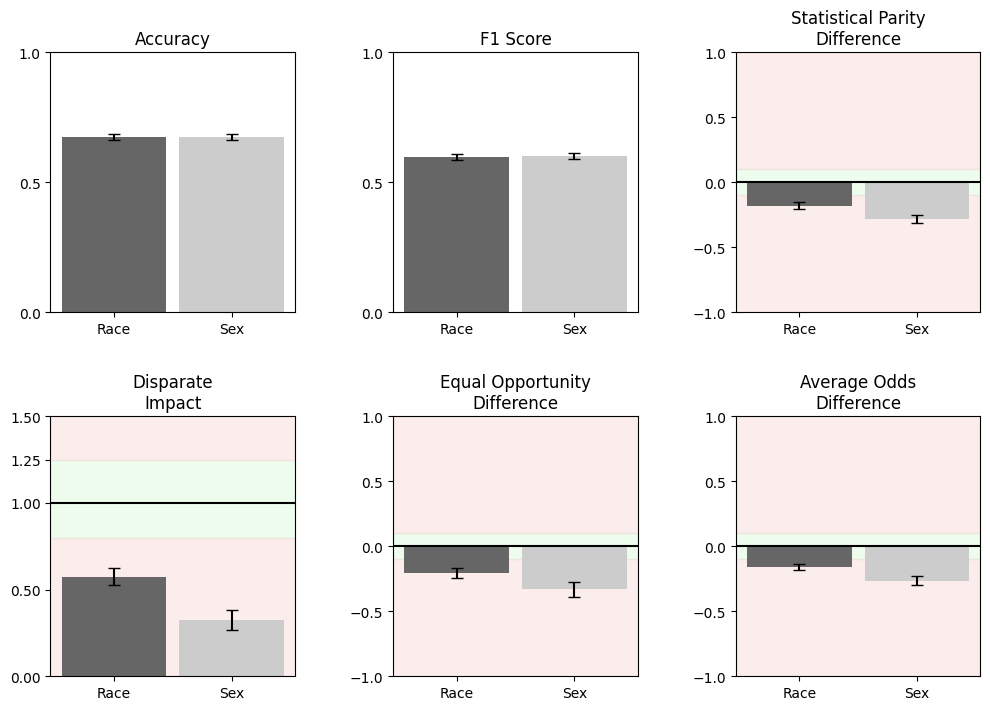

In [9]:
compare_viz_metrics_2x3(compas_race_metrics_agg, compas_sex_metrics_agg, 'Race', 'Sex')